Hi, in this notebook I'll try to analyse data for this competition and make predictions using fast.ai's tablular learner library.

In [1]:
# Installing fastai's fastbook library

! pip install -Uqq fastbook
import fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.6 MB/s eta 0:00:00


In [2]:
from fastbook import *
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
import warnings
warnings.filterwarnings('ignore')

By setting the path variable as base path we can then use it as reference and don't have to type the entire path, we can also use .ls() method to list out the files in the path.

In [4]:
path = Path('/kaggle/input/playground-series-s5e2')
Path.BASE_PATH = path

In [5]:
path.ls()

(#4) [Path('sample_submission.csv'),Path('train.csv'),Path('test.csv'),Path('training_extra.csv')]

In [6]:
df_train = pd.read_csv(path/'train.csv')
df_extra = pd.read_csv(path/'training_extra.csv')
df_test = pd.read_csv(path/'test.csv')

In [7]:
df = pd.concat([df_train,df_extra],axis=0).reset_index(drop=True)

In [8]:
df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [9]:
df.isna().sum()

id                           0
Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Categorical and numerical columns
categorical_cols = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
numerical_cols = ['Weight Capacity (kg)', 'Price']

Let's look at the data one column at a time, we're looking at the count of the categorical variables and distribution of the numerical columns. Looking at the charts belows it looks like data is almost equally distributed between the different categories in each column.

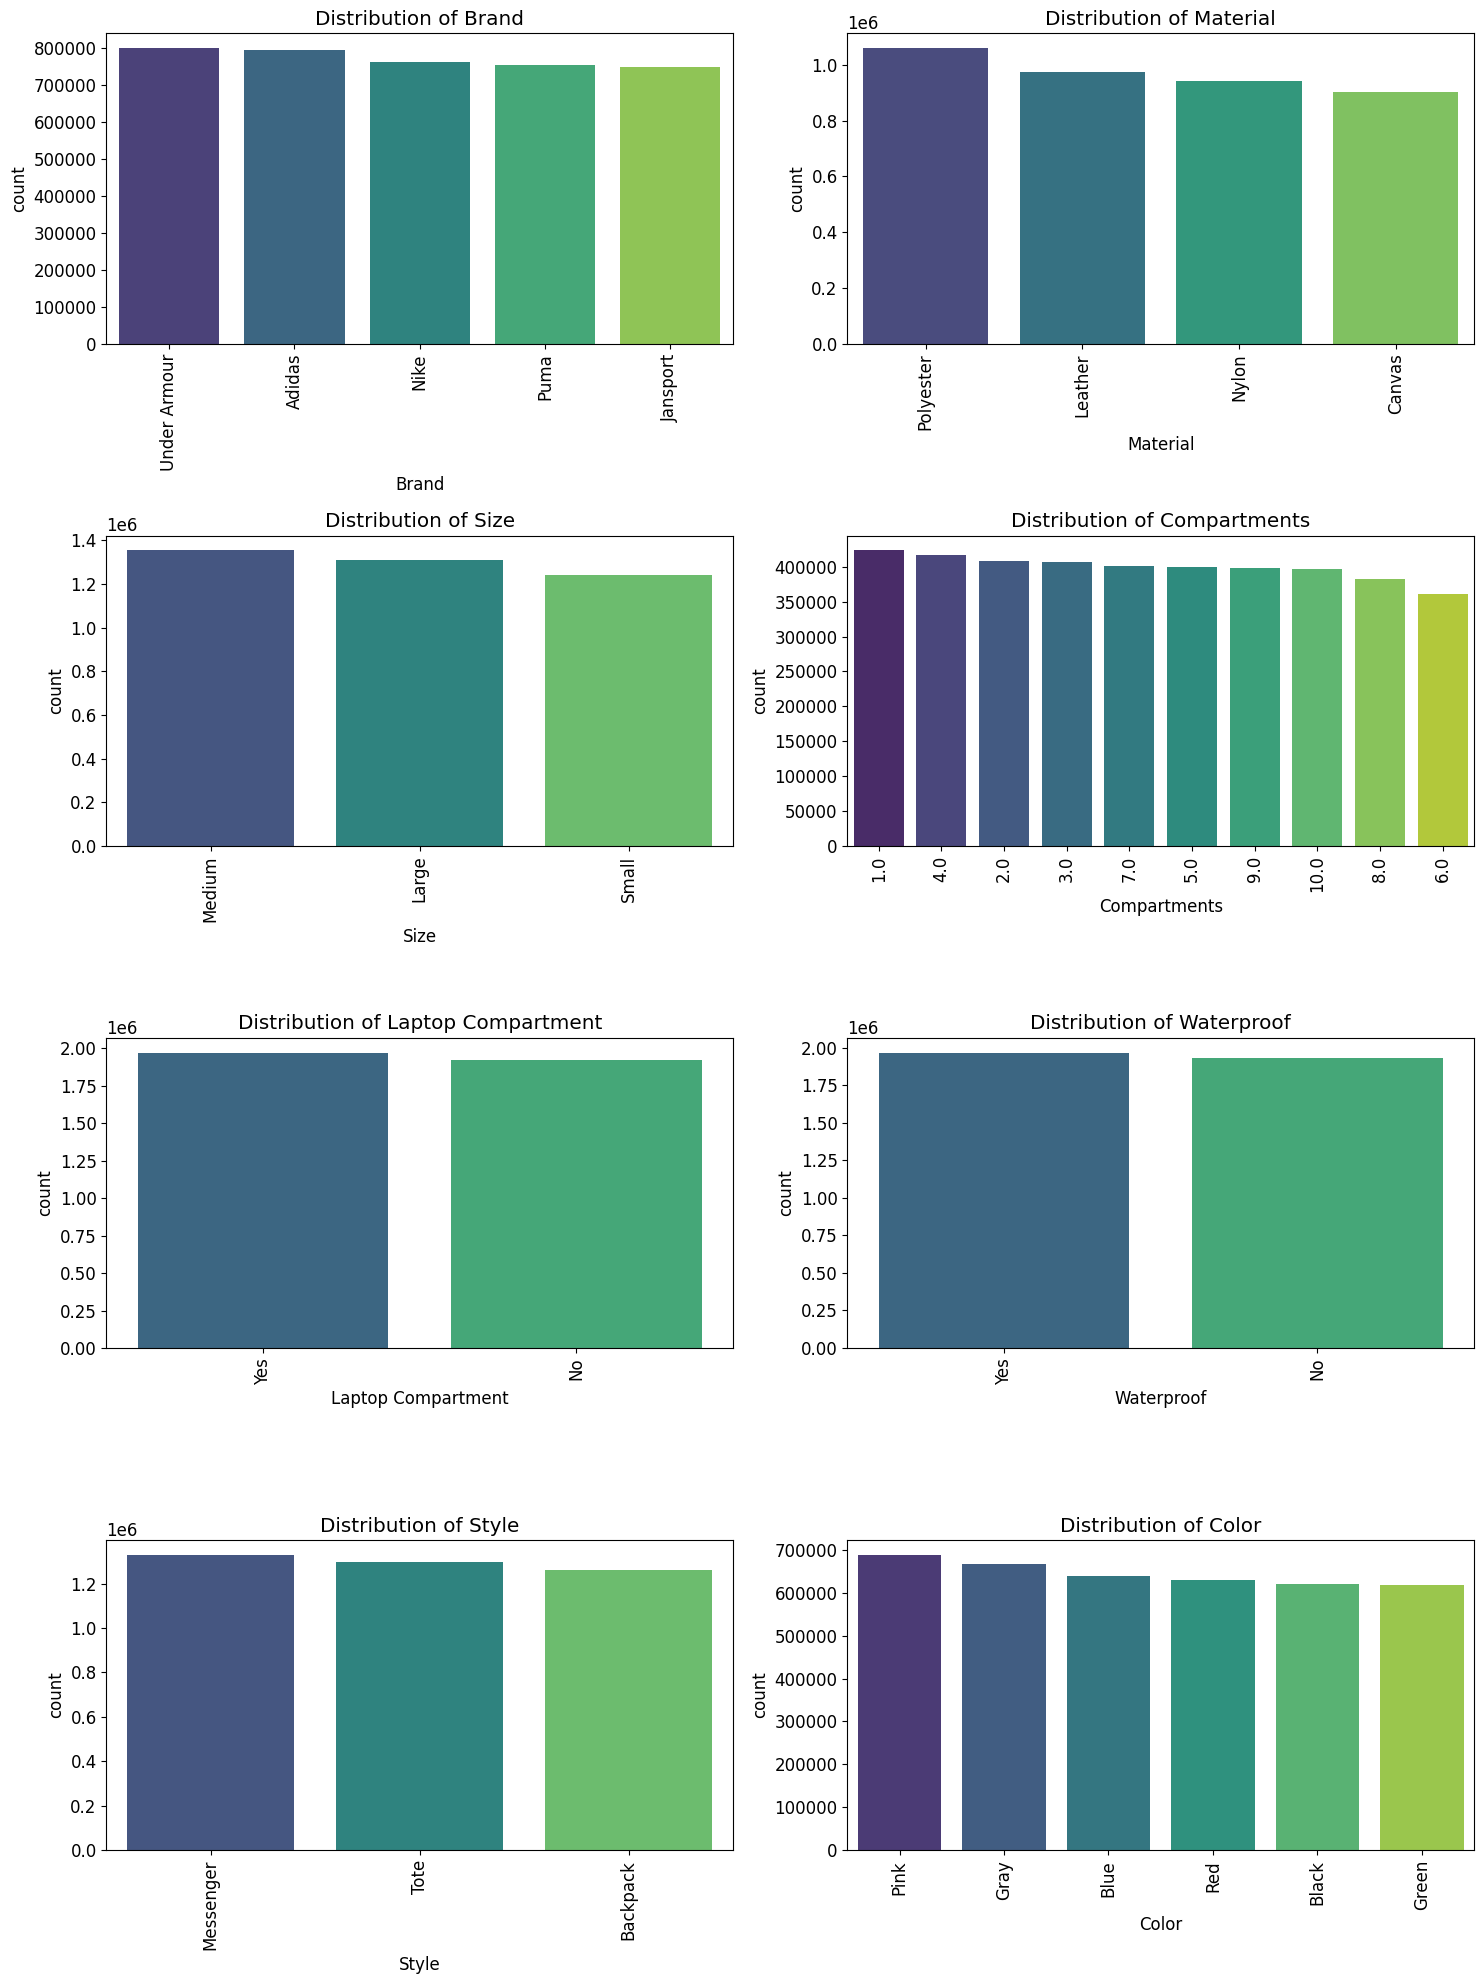

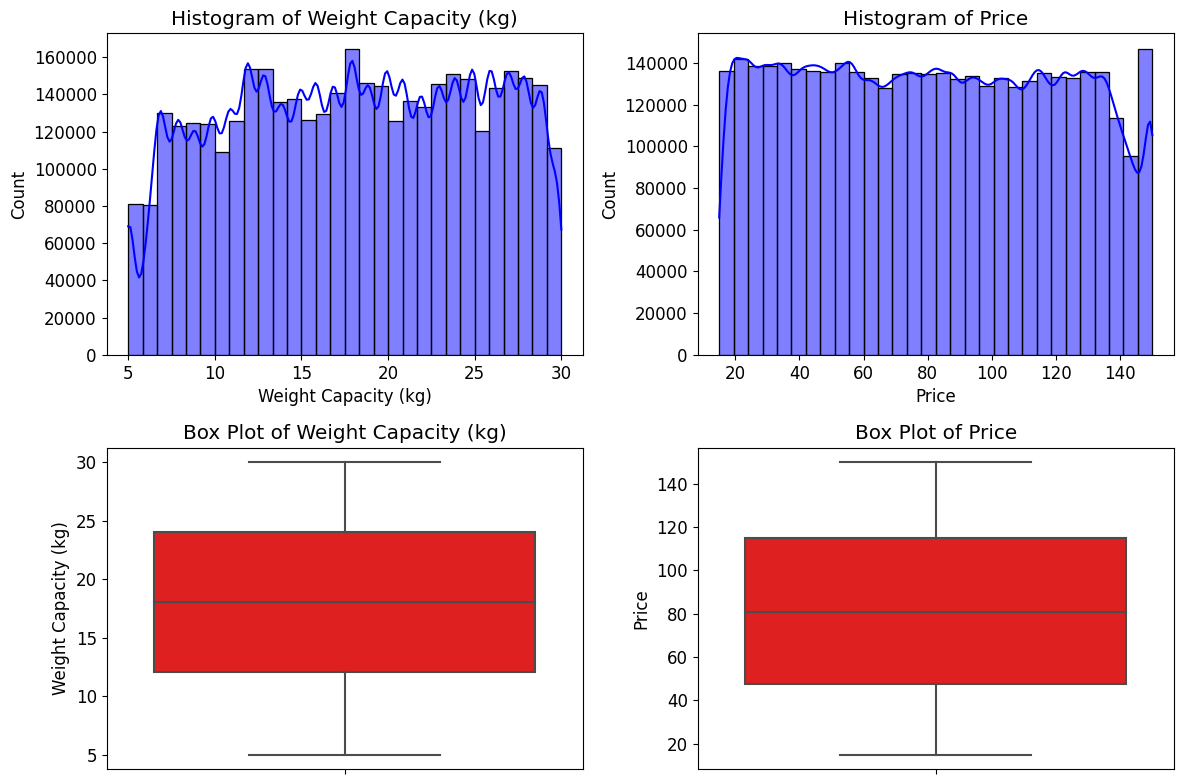

In [12]:
# 1. UNIVARIATE ANALYSIS

# Categorical Variables - Count Plots
fig, axes = plt.subplots(nrows=len(categorical_cols)//2 + len(categorical_cols)%2, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], data=df, ax=axes[i], order=df[col].value_counts().index, palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Numerical Variables - Histograms & Box Plots
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_cols), figsize=(12, 8))

# Histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0, i], color='blue')
    axes[0, i].set_title(f'Histogram of {col}')

# Box Plots (Check for Outliers)
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[1, i], color='red')
    axes[1, i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

Now let's look at the distribution of the data with respect to the target column (Price). Again it looks like the data is uniformally distributed among different categories w.r.t. price of the backpack.

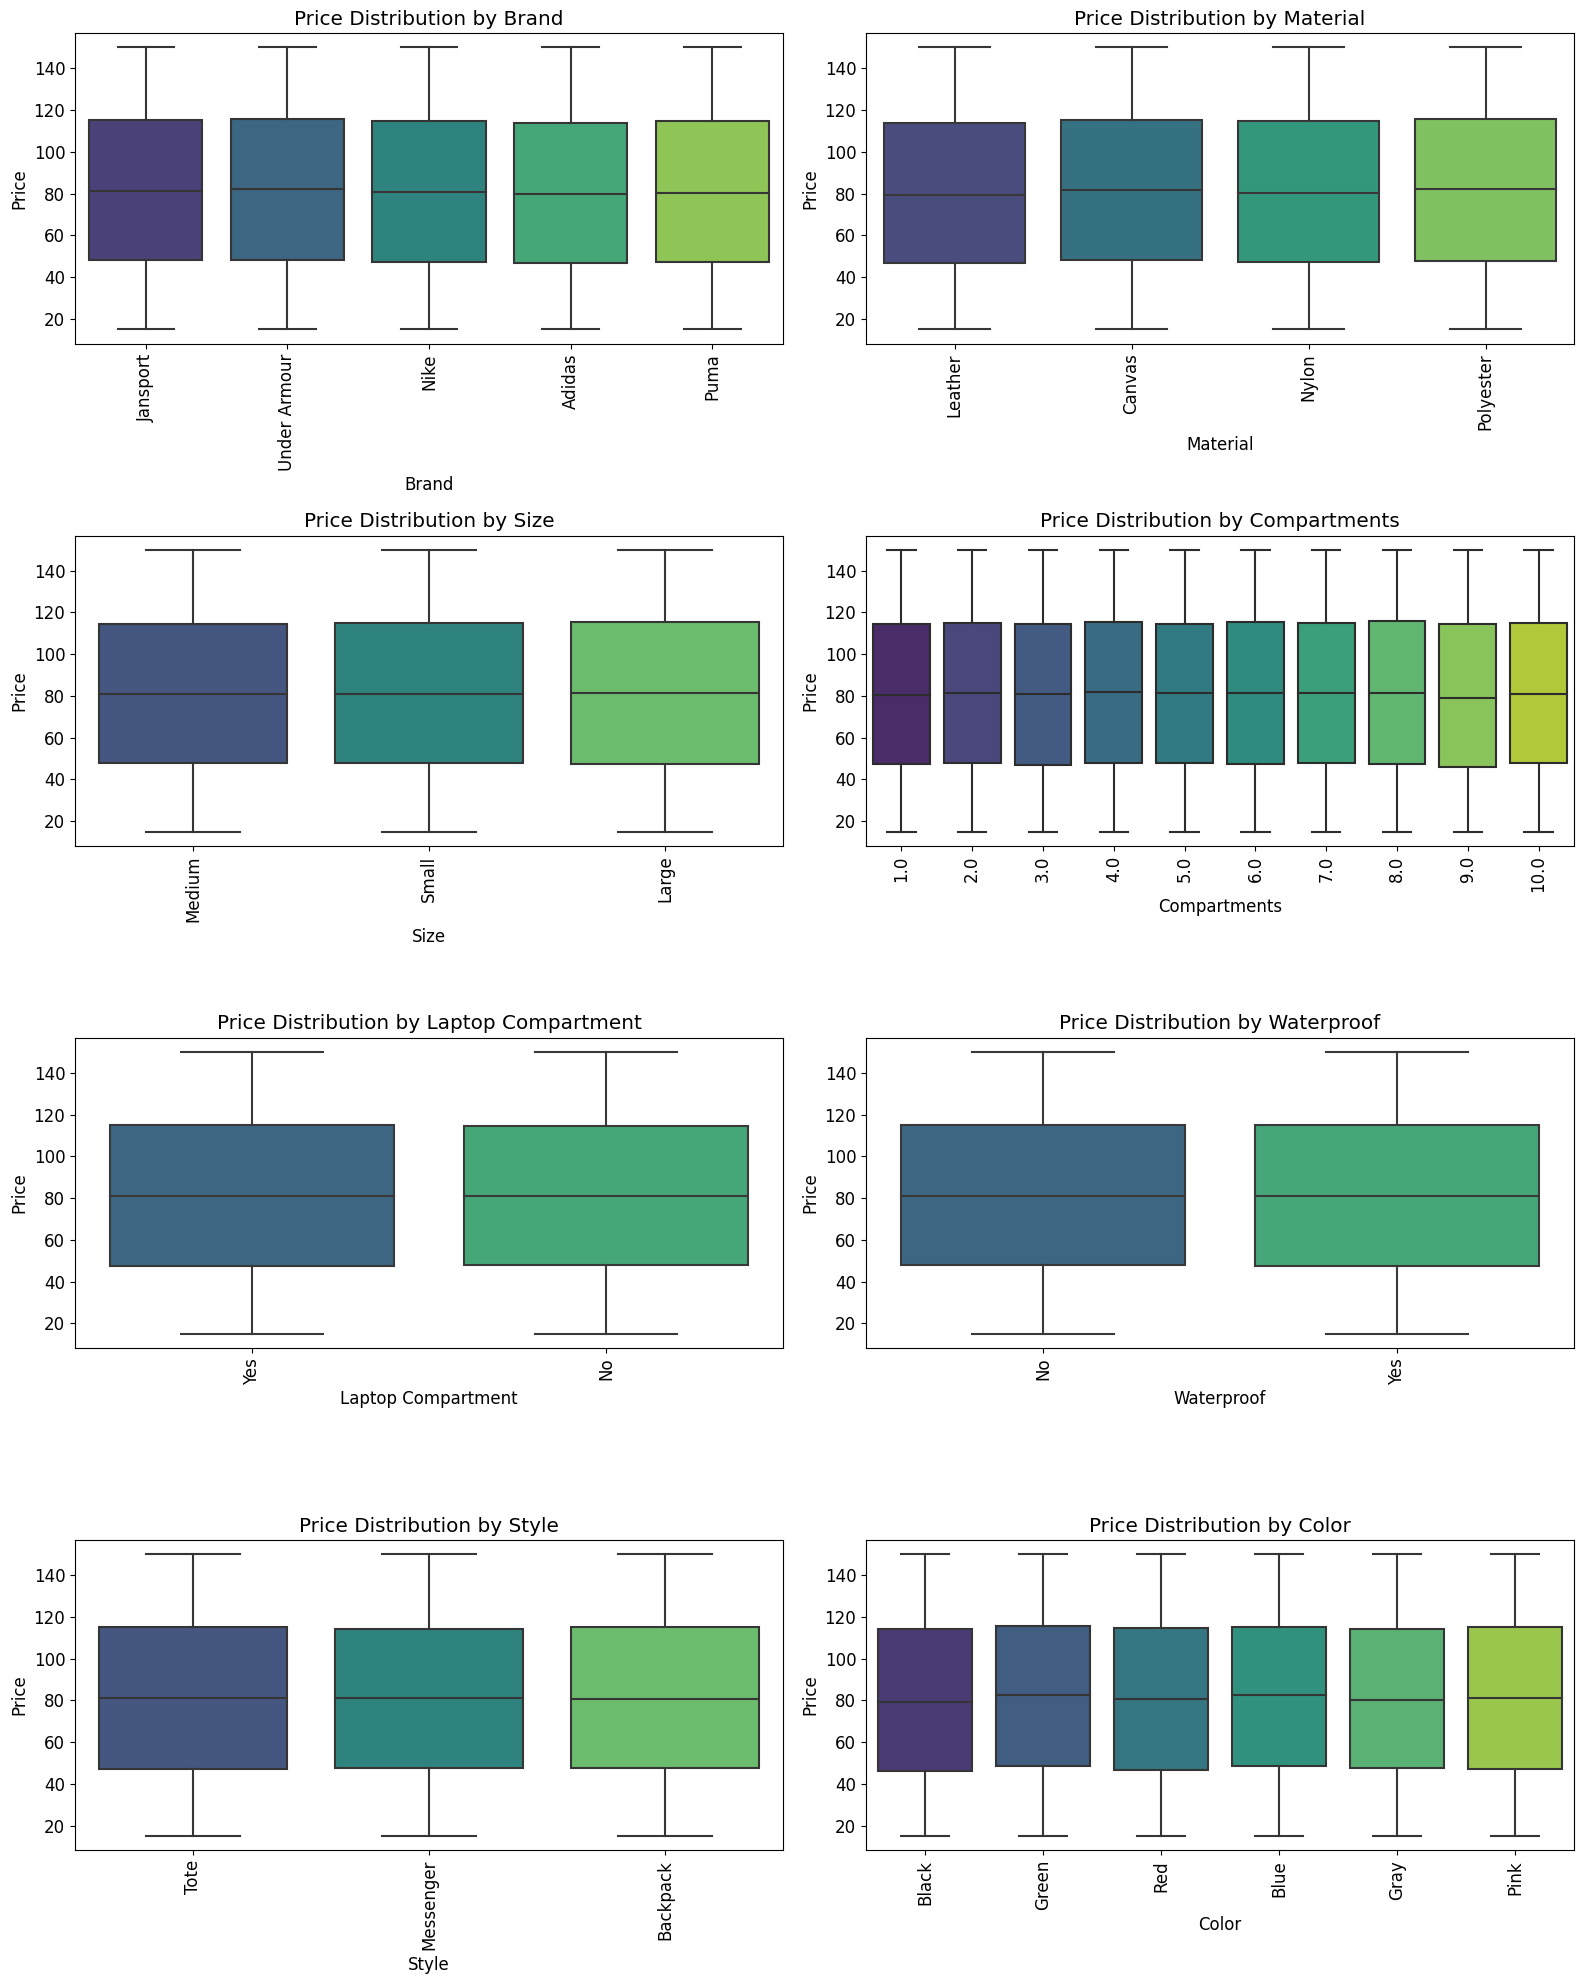

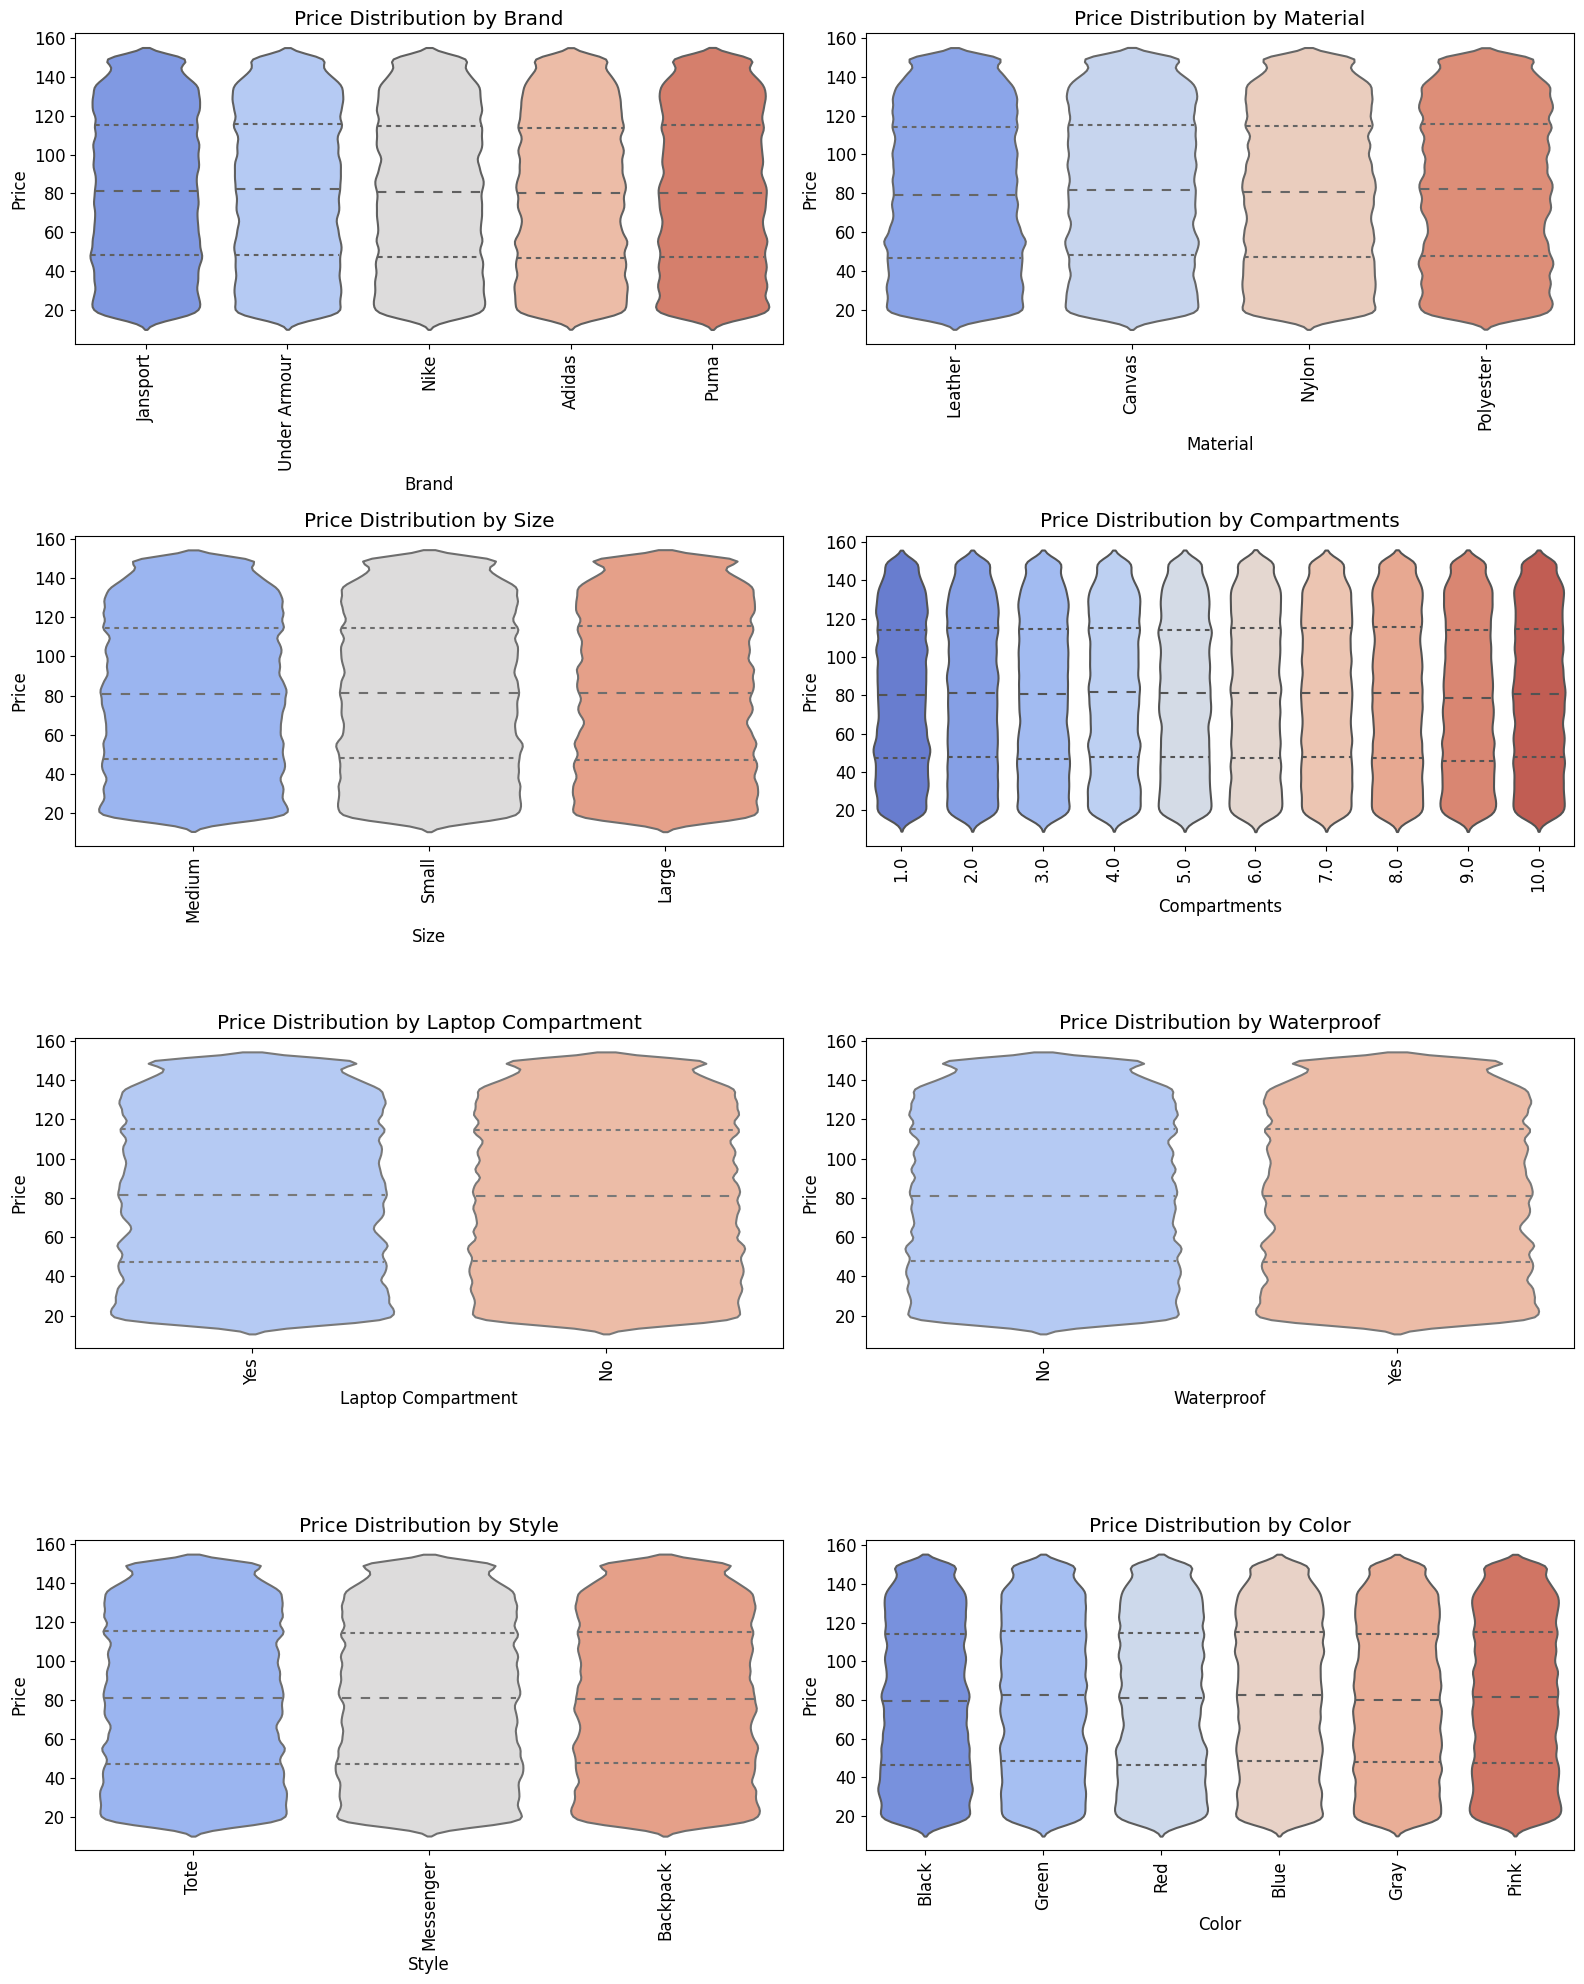

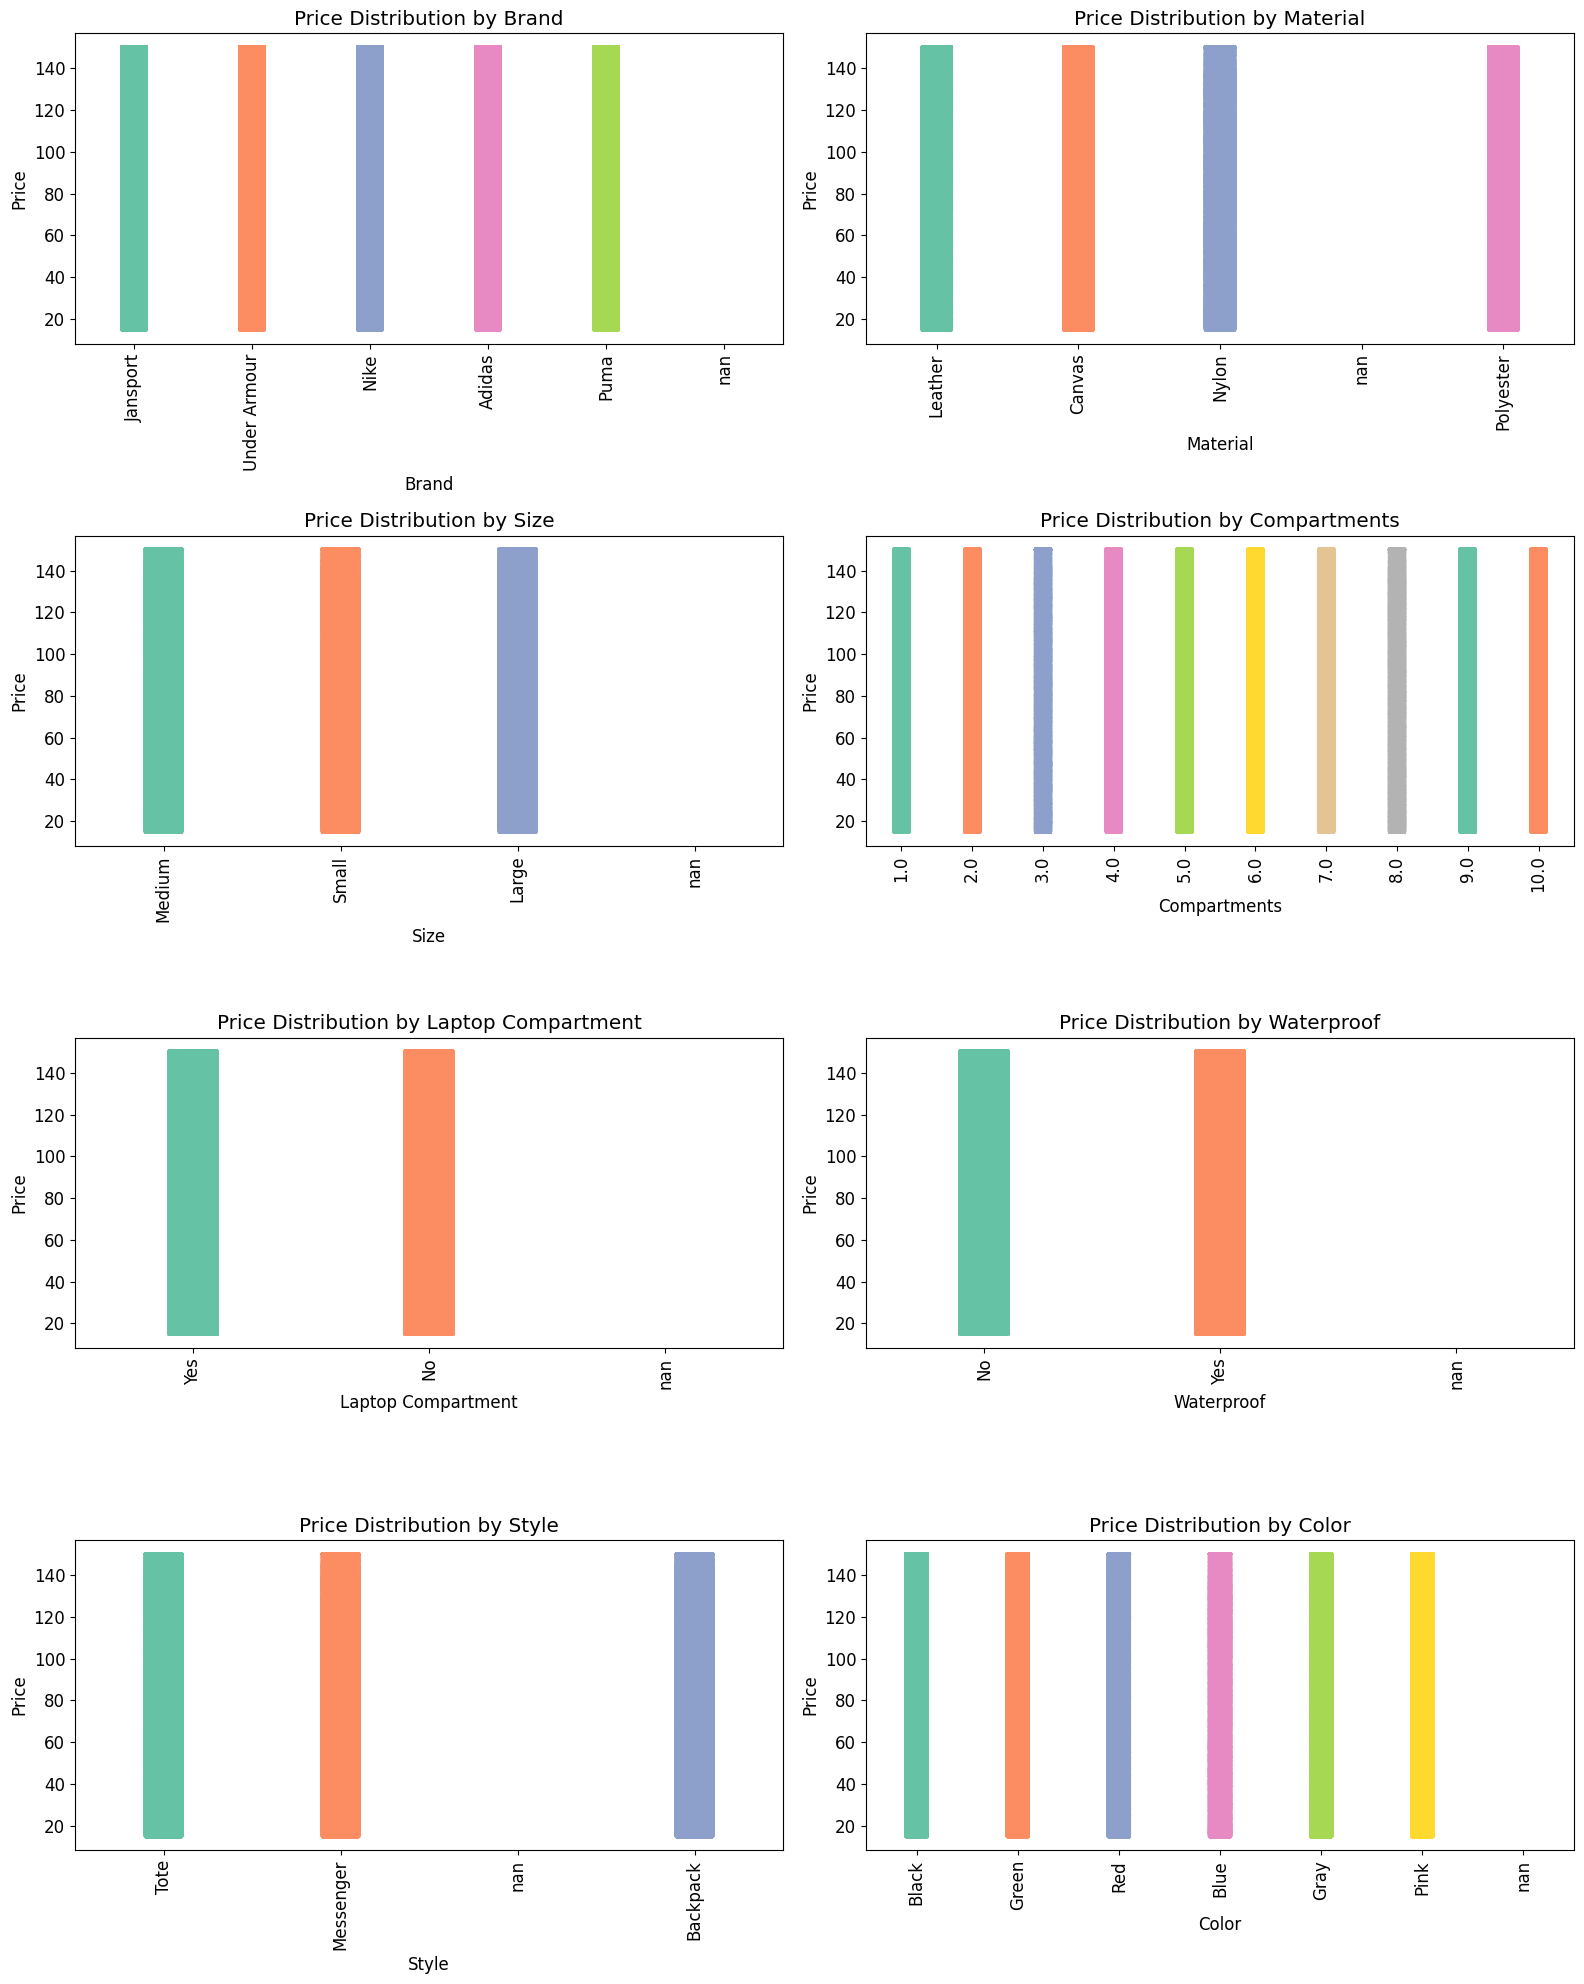

In [13]:
# 2. BIVARIATE ANALYSIS

# Price Distribution Across Categorical Features - Box Plots
fig, axes = plt.subplots(nrows=len(categorical_cols)//2 + len(categorical_cols)%2, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=df[col], y=df['Price'], data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Violin Plots (Show Price Density)
fig, axes = plt.subplots(nrows=len(categorical_cols)//2 + len(categorical_cols)%2, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.violinplot(x=df[col], y=df['Price'], data=df, ax=axes[i], palette='coolwarm', inner='quartile')
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Strip Plot
fig, axes = plt.subplots(nrows=len(categorical_cols)//2 + len(categorical_cols)%2, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.stripplot(x=df[col], y=df['Price'], data=df, ax=axes[i], palette='Set2', jitter=True, size=3, alpha=0.5)
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


Now let's look at how backpack's weight is related to it's price. Looking at the scatter plot it looks like noise, there's no clear correlation, also the correlation coefficient between weight and price is 0.018, which indicated there's virtually no correlation.

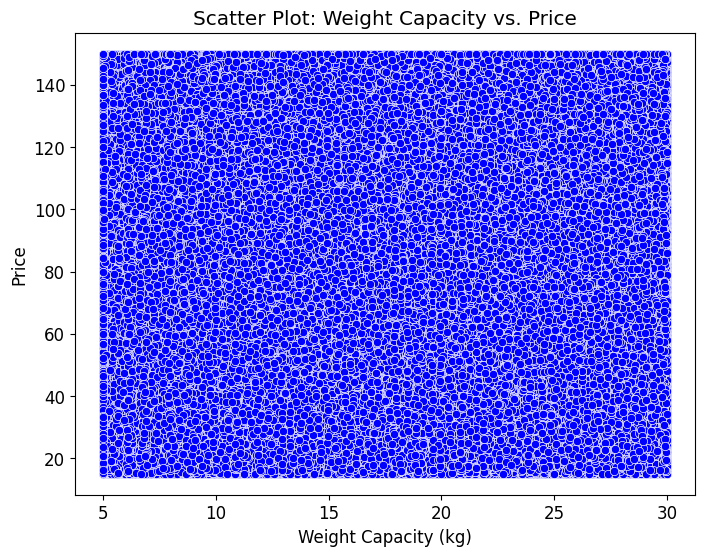

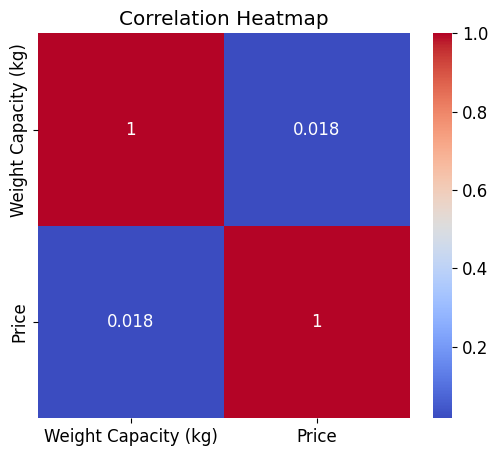

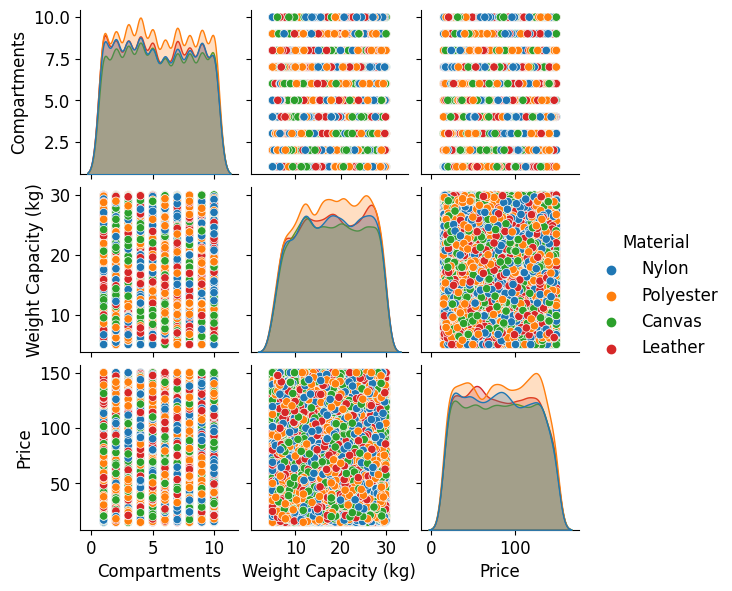

In [14]:
# 3. RELATIONSHIP BETWEEN NUMERICAL FEATURES

# Scatter Plot: Weight Capacity vs. Price
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Weight Capacity (kg)'], y=df['Price'], color='blue')
plt.title("Scatter Plot: Weight Capacity vs. Price")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df[['Weight Capacity (kg)', 'Price']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Pairplot to visualize numeric relationships
sns.pairplot(df.drop(columns=['id']).sample(50000), hue="Material", diag_kind="kde", height=2)
plt.show()

In [15]:
df['Price'].min(), df['Price'].max()

(15.0, 150.0)

Looking at the skewness of the numerical columns there's no need of taking a log so we'll leave it as is.

In [16]:
skewness = df[numerical_cols].skew()

# Display skewness values
print("Skewness of numerical features:")
print(skewness)

Skewness of numerical features:
Weight Capacity (kg)   -0.061311
Price                   0.036958
dtype: float64


In [17]:
print(df.Size.unique())
print(df.Compartments.unique())

['Medium' 'Small' 'Large' nan]
[ 7. 10.  2.  8.  1.  3.  5.  9.  6.  4.]


In [18]:
df.Size.dtype, df.Compartments.dtype

(dtype('O'), dtype('float64'))

Columns Size and Compartments should be ordinal columns so let's change their type to category and assign the values in order.

In [19]:
sizes = 'Large', 'Medium', 'Small'
df['Size'] = df['Size'].astype('category')
df['Size'] = df['Size'].cat.set_categories(sizes, ordered=True)

compartments = 10,9,8,7,6,5,4,3,2,1
df['Compartments'] = df['Compartments'].astype('category')
df['Compartments'] = df['Compartments'].cat.set_categories(compartments, ordered=True)

In [20]:
df_test['Size'] = df_test['Size'].astype('category')
df_test['Size'] = df_test['Size'].cat.set_categories(sizes, ordered=True)

df_test['Compartments'] = df_test['Compartments'].astype('category')
df_test['Compartments'] = df_test['Compartments'].cat.set_categories(compartments, ordered=True)

In [21]:
df.Size.dtype, df.Compartments.dtype

(CategoricalDtype(categories=['Large', 'Medium', 'Small'], ordered=True, categories_dtype=object),
 CategoricalDtype(categories=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1], ordered=True, categories_dtype=int64))

We can look at the assigned codes using ".cat.code" on the column.

In [22]:
df.Size.cat.codes.head(10)

0    1
1    2
2    2
3    2
4    1
5    1
6    0
7    2
8    1
9    1
dtype: int8

Let's spilit the data into training and validation sets.

In [23]:
train_idx, valid_idx = train_test_split(df.index, test_size=0.2, random_state=42)

In [24]:
train_idx, valid_idx

(Index([2730815, 2453018, 3789433, 1359411, 1312217, 2995401, 2602855, 3475858,
        2076860, 3588090,
        ...
        2234489, 3200614,  732180,  110268, 1692743, 2356330, 3511566, 2229084,
        2768307, 2219110],
       dtype='int64', length=3195454),
 Index([  56569, 1183394,  855407,  239037, 1855852, 3546568, 1115121,  549371,
        1695582, 3682811,
        ...
         503154, 1573386, 2225835, 2209703, 3292913,  482334, 1474100, 1537071,
         972131, 3600030],
       dtype='int64', length=798864))

In [25]:
numerical_cols = ['Weight Capacity (kg)']
categorical_cols, numerical_cols

(['Brand',
  'Material',
  'Size',
  'Compartments',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color'],
 ['Weight Capacity (kg)'])

Let's build our tabular pandas objcet that'll help us build the dataloader (we can build the dataloader directly but this way we can breaks the process down and we can use the tablular pandas object to run other machine learning models like random forest).

We need to tell the tablular pandas what sort of oprations we would like to perform on our dataframe, here we're telling it to categoryfy the object columns, fill the missing values and normalize the numerical columns, we're also passing a list of categorical and numerical columns.

In [26]:
procs = [Categorify, FillMissing, Normalize]
splits = (list(train_idx),list(valid_idx))
to = TabularPandas(df.drop(columns=['id']), procs, categorical_cols, numerical_cols, y_names='Price', splits=splits)

In [27]:
len(to.train), len(to.valid)

(3195454, 798864)

We can look at the first few rows just like pandas dataframe but with .show() instead of .head()

In [28]:
to.show(3)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)_na,Weight Capacity (kg),Price
2730815,Puma,Nylon,Small,7,Yes,Yes,Backpack,Green,False,8.812587,143.979279
2453018,Adidas,Canvas,Small,5,No,No,Backpack,Pink,False,29.273634,89.075180
3789433,Adidas,Canvas,#na#,9,No,No,Tote,Green,False,22.482912,65.106178


We can also look at how it has transoformed our dataframe (categorical features are encoded and weight has been normalized)

In [29]:
to.items.head(3)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Weight Capacity (kg)_na
2730815,4,3,3,4,2,2,1,4,-1.320727,143.979279,1
2453018,1,1,3,6,1,1,1,5,1.616735,89.075180,1
3789433,1,1,0,2,1,1,3,4,0.641835,65.106178,1


We can look at the "classes" it has assigned to the values in a columns. #na# is a assigned to the missing values, fast.ai keeps track of the missing values as it also might help us in training if we keep track of the data points that were missing.

In [30]:
to.classes['Size']

['#na#', 'Large', 'Medium', 'Small']

We'll now fit a randomforest regressor to prepare a baseline and it'll also help us determine which columns are important to keep and which columns we can discard.

In [31]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [32]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [33]:
model = rf(xs, y);

In [34]:
error = mean_squared_error(model.predict(valid_xs), valid_y)
error, np.sqrt(error)

(1524.3611794563315, 39.043068263858714)

In [35]:
oob_error = mean_squared_error(model.oob_prediction_, y)
oob_error

1527.4458212365773

Let's look at the feature importance of the independent variables.

In [36]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [37]:
fi = rf_feat_importance(model, xs)
fi

,cols,imp
9,Weight Capacity (kg),0.472003
3,Compartments,0.127587
7,Color,0.078629
0,Brand,0.067732
6,Style,0.064298
2,Size,0.058314
1,Material,0.045696
4,Laptop Compartment,0.042813
5,Waterproof,0.042574
8,Weight Capacity (kg)_na,0.000353


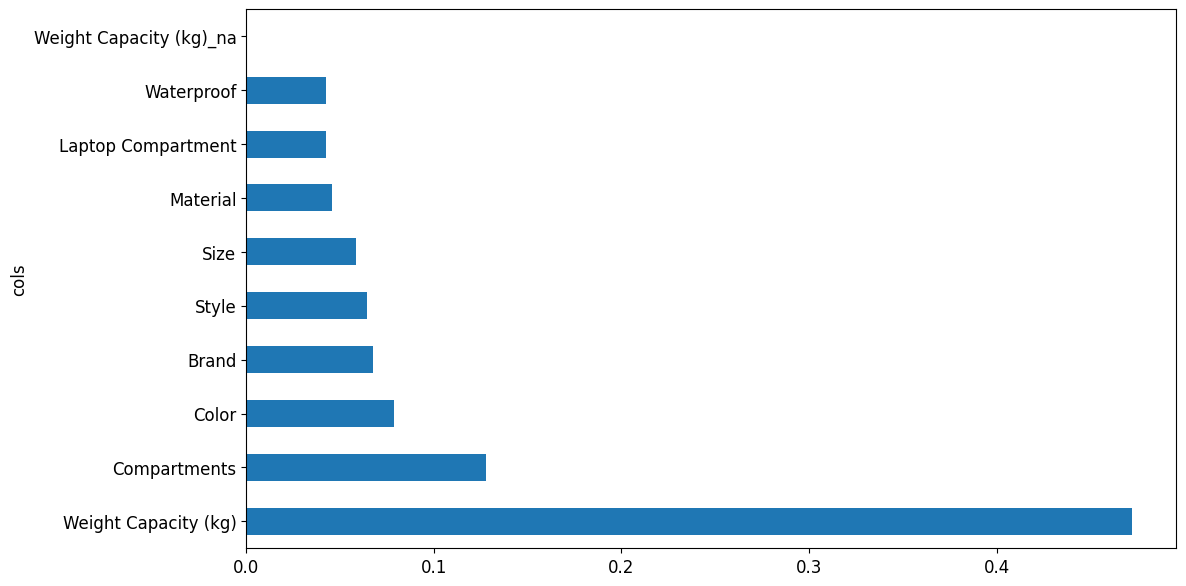

In [38]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

We'll keep the variables with feature importance > 0.05

In [39]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep), to_keep

(6,
 9    Weight Capacity (kg)
 3            Compartments
 7                   Color
 0                   Brand
 6                   Style
 2                    Size
 Name: cols, dtype: object)

In [40]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [41]:
xs_imp.head()

,Weight Capacity (kg),Compartments,Color,Brand,Style,Size
2730815,-1.320727,4,4,4,1,3
2453018,1.616735,6,5,1,1,3
3789433,0.641835,2,4,1,3,0
1359411,0.079585,3,6,1,2,3
1312217,-0.406432,9,4,4,1,1


In [42]:
model = rf(xs_imp, y)

In [43]:
error = mean_squared_error(model.predict(valid_xs_imp), valid_y)
error, np.sqrt(error)

(1527.7338603659703, 39.08623620107173)

In [44]:
df_test.head(3)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9,No,Yes,Messenger,Blue,11.809799


Let's make the prediction on the test set, we'll prepare the same tabular pandas object for the test set.

In [45]:
to_test = TabularPandas(df_test.drop(columns=['id']), procs, categorical_cols, numerical_cols)

In [46]:
to_test.show(3)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)_na,Weight Capacity (kg)
0,Puma,Leather,Small,2,No,No,Tote,Green,False,20.671146
1,Nike,Canvas,Medium,7,No,Yes,Backpack,Green,False,13.564105
2,Adidas,Canvas,Large,9,No,Yes,Messenger,Blue,False,11.809799


In [47]:
test_xs = to_test.train.xs[to_keep]
test_xs.head()

,Weight Capacity (kg),Compartments,Color,Brand,Style,Size
0,0.384195,9,4,4,3,3
1,-0.635370,4,4,3,1,2
2,-0.887040,2,2,1,2,1
3,0.069431,10,4,1,2,1
4,-1.159876,9,1,0,3,1


In [48]:
preds = model.predict(test_xs)

In [49]:
sub = pd.read_csv(path/'sample_submission.csv')
sub.head()

,id,Price
0,300000,81.411
1,300001,81.411
2,300002,81.411
3,300003,81.411
4,300004,81.411


In [50]:
sub['Price'] = preds
sub.head()

,id,Price
0,300000,77.979732
1,300001,76.221735
2,300002,88.478210
3,300003,85.197131
4,300004,77.089532


In [51]:
sub.to_csv('RF_Preds_Base.csv', index=False)

Now let's move on to the deep learning, we'll prepare the dataloader which will feed the data to our model.

In [52]:
dls = to.dataloaders(1024)

In [53]:
dls.show_batch()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)_na,Weight Capacity (kg),Price
0,Under Armour,Leather,Large,10,Yes,No,Messenger,Black,False,22.088814,128.851166
1,Adidas,#na#,Small,1,Yes,Yes,Tote,Gray,False,23.787083,113.793732
2,Puma,Nylon,Small,4,No,Yes,Tote,Blue,False,12.606485,89.744164
3,Nike,Canvas,Medium,9,Yes,Yes,Messenger,Black,False,13.095919,18.386530
4,Jansport,Polyester,Large,3,Yes,No,Backpack,Blue,False,14.281607,49.412048
5,Jansport,Leather,Medium,9,Yes,No,#na#,Black,False,5.000000,125.705711
6,Adidas,Canvas,Medium,3,No,No,Backpack,Black,False,8.362516,64.496094
7,Jansport,Leather,Medium,9,No,No,Tote,#na#,False,27.807691,22.496111
8,Jansport,Nylon,Small,1,Yes,No,Messenger,Black,False,19.822836,61.907539
9,Under Armour,Canvas,Large,7,Yes,No,Backpack,Black,False,9.455335,76.066231


The range of the data is from 15 to 150, which we'll pass to our model.

In [54]:
y = to.train.y
y.min(), y.max()

(15.0, 150.0)

In [55]:
learn = tabular_learner(dls, y_range=(14,155), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

The fast.ai set-up provides a method to find the optimal learning rate. We should select the learning rate with the best slope (not the lowest one in the graph as we want our model to learn), here we'll select 0.01.

SuggestedLRs(valley=0.0004786300996784121)

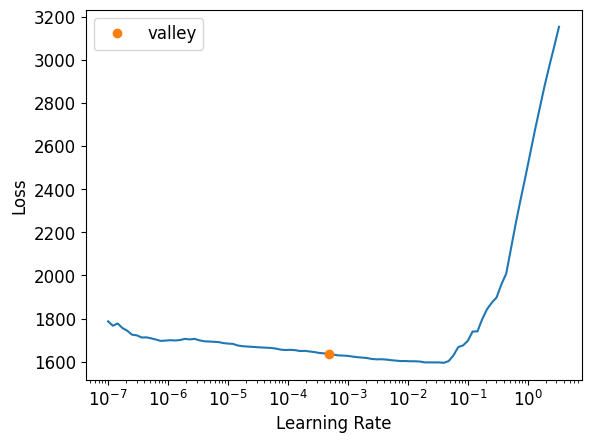

In [56]:
learn.lr_find()

Let's run the model for 10 epochs.

In [57]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,1521.240479,1522.972168,00:36
1,1512.602173,1513.182617,00:36
2,1517.859741,1518.193970,00:37
3,1511.138184,1514.440430,00:38
4,1511.227661,1513.513672,00:37
5,1517.251221,1513.805420,00:37
6,1511.016113,1512.952026,00:36
7,1511.587402,1513.326538,00:36
8,1522.126343,1511.724854,00:36
9,1510.728516,1513.062988,00:35


The model is done trianing now, let's prepare our test dataloader for predictions.

In [58]:
test_dl = learn.dls.test_dl(df_test.drop(columns=['id']))

In [59]:
test_dl.show_batch()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)_na,Weight Capacity (kg)
0,Puma,Leather,Small,2,No,No,Tote,Green,False,20.671147
1,Nike,Canvas,Medium,7,No,Yes,Backpack,Green,False,13.564105
2,Adidas,Canvas,Large,9,No,Yes,Messenger,Blue,False,11.809799
3,Adidas,Nylon,Large,1,Yes,No,Messenger,Green,False,18.477036
4,#na#,Nylon,Large,2,Yes,Yes,Tote,Black,False,9.907953
5,Under Armour,Nylon,Medium,8,No,No,Backpack,Black,False,17.547673
6,Nike,Nylon,Large,8,No,Yes,Tote,Blue,False,16.003025
7,Jansport,Polyester,Medium,6,Yes,No,Backpack,Blue,False,24.238091
8,Nike,Canvas,Large,8,Yes,Yes,Backpack,Red,False,19.181167
9,Puma,Leather,Large,1,No,No,Tote,Blue,False,9.937962


In [60]:
preds,_ = learn.get_preds(dl=test_dl)

In [61]:
preds = preds.squeeze(dim=1).numpy()

In [62]:
sub['Price'] = preds

In [63]:
sub.head(5)

,id,Price
0,300000,82.331192
1,300001,83.241692
2,300002,80.498222
3,300003,81.379204
4,300004,80.291199


In [64]:
sub.to_csv('NN_Basic.csv', index=False)

One extra thing we can try is to stack a bunch of these models and take average of their predictions, this is a simple ensembling technique but it works great.

In [65]:
def ensemble():
    learn = tabular_learner(dls, y_range=(15,150), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
    with learn.no_logging(): learn.fit(10, lr=1e-2)
    return learn.get_preds(dl=test_dl)[0]

In [66]:
learns = [ensemble() for _ in range(5)]

In [67]:
preds = torch.stack(learns).mean(0)

In [68]:
sub['Price'] = preds

In [69]:
sub.head(5)

,id,Price
0,300000,81.822891
1,300001,82.801224
2,300002,80.473106
3,300003,80.938354
4,300004,79.433182


In [70]:
sub.to_csv('NN_Ensemble.csv', index=False)

There it is, we've performed EDA, fit a randome forest model, checked the feature importance of the variables and then finally used a neural net to train on our data and make predictions. Thanks for reading! :)